# Forcast.io API

### Setup

In [91]:
import requests
import sqlite3 as lite
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.parser import parse
import collections
from mpl_toolkits.basemap import Basemap
from matplotlib import cm

In [40]:
%matplotlib inline

In [33]:
api_key = '3e52065bfc397b97827bb0345579ba2f/'

In [34]:
url = 'https://api.forecast.io/forecast/' + api_key

In [15]:
cities = { "Dallas": '32.7767,-96.7970',
            "Austin": '30.303936,-97.754355',
            "Boston": '42.331960,-71.020173',
            "Chicago": '41.837551,-87.681844',
            "San_Bernardino": '34.1083,-117.2898'
        }

In [21]:
end_date = datetime.datetime.now()

### Place data in DB for 5 cities over the last 30 days

In [96]:
con = lite.connect('weather.db')
cur = con.cursor()

In [8]:
cities.keys()

['Boston', 'San Bernardino', 'Chicago', 'Austin', 'Dallas']

In [97]:
','.join((x + ' REAL' for x in cities.keys()))

'Boston REAL,Chicago REAL,Austin REAL,San_Bernardino REAL,Dallas REAL'

In [25]:
cur.execute('DROP TABLE daily_temp')

In [26]:
with con:
    cur.execute('CREATE TABLE daily_temp (day_of_reading,' + ','.join((x + ' REAL' for x in cities.keys())) + ');')

In [23]:
query_date = end_date - datetime.timedelta(days = 30)

In [27]:
with con:
    while query_date < end_date:
        cur.execute('INSERT INTO daily_temp (day_of_reading) VALUES (?)', (int(query_date.strftime('%s')),))
        query_date += datetime.timedelta(days = 1)

In [31]:
query_date

datetime.datetime(2016, 5, 26, 19, 18, 8, 142986)

In [35]:
for k,v in cities.iteritems():
    query_date = end_date - datetime.timedelta(days = 30)
    while query_date < end_date:
        r = requests.get(url + v + ',' + query_date.strftime('%Y-%m-%dT12:00:00'))
        
        with con:
            cur.execute('UPDATE daily_temp SET ' + k + ' = ' + str(r.json()['daily']['data'][0]['temperatureMax']) +
                        ' WHERE day_of_reading = ' + query_date.strftime('%s'))
        query_date += datetime.timedelta(days = 1)
con.close()

### Load data from DB and find variation of temperatures over the 30 days

In [41]:
temps = pd.read_sql_query('SELECT * FROM daily_temp ORDER BY day_of_reading',con,index_col = 'day_of_reading')

In [42]:
temps.head()

,Boston,Chicago,Austin,San_Bernardino,Dallas
day_of_reading,,,,,
1464308288,75.15,83.84,87.49,75.76,80.93
1464394688,69.49,80.07,76.71,82.28,79.84
1464481088,89.58,82.00,90.00,79.97,85.99
1464567488,76.80,79.51,88.00,75.71,87.02
1464653888,73.37,78.59,88.36,81.75,83.72


In [47]:
temp_change = collections.defaultdict(int)

In [48]:
for col in temps.columns:
    vals = temps[col].tolist()
    change = 0
    for k,v in enumerate(vals):
        if k < len(vals) - 1:
            change += abs(vals[k] - vals[k+1])
    temp_change[col] = change 

In [49]:
temp_change

defaultdict(int,
            {'Austin': 67.480000000000004,
             'Boston': 173.56,
             'Chicago': 138.59,
             'Dallas': 67.04000000000002,
             'San_Bernardino': 146.87999999999994})

### Which cities have the max and min temperature swings?

In [50]:
def keyWithMaxVal(d):
    '''Find key with greatest value change'''
    return max(d, key = lambda k: d[k])

In [53]:
def keyWithMinVal(d):
    '''Find key with greatest value change'''
    return min(d, key = lambda k: d[k])

In [52]:
maxTempSwings = keyWithMaxVal(temp_change)
print('The city with the largest temperature swings over the last 30 days '
      'is %s with an overall change of %d degrees.' %
         (maxTempSwings, temp_change[maxTempSwings],))

The city with the largest temperature swings over the last 30 days is Boston with an overall change of 173 degrees.


In [54]:
minTempSwings = keyWithMinVal(temp_change)
print('To contrast, the city with the smallest temperature swings over the last 30 days '
          'is %s with an overall change of %d degrees.' %
         (minTempSwings, temp_change[minTempSwings],))

To contrast, the city with the smallest temperature swings over the last 30 days is Dallas with an overall change of 67 degrees.


### Dallas may be the most consistent, but the problem is it is consistently too hot!

In [55]:
temps.mean()

Boston            74.088667
Chicago           79.620000
Austin            89.635667
San_Bernardino    86.927000
Dallas            89.152000
dtype: float64

In [56]:
temps.median()

Boston            73.780
Chicago           79.760
Austin            90.785
San_Bernardino    86.255
Dallas            90.645
dtype: float64

### From the stacked histogram we see that San Bernardino is the only city that is going over 100, Dallas and Austin have relatively similar temperatures, and Boston is a nice place to vacation in the summer

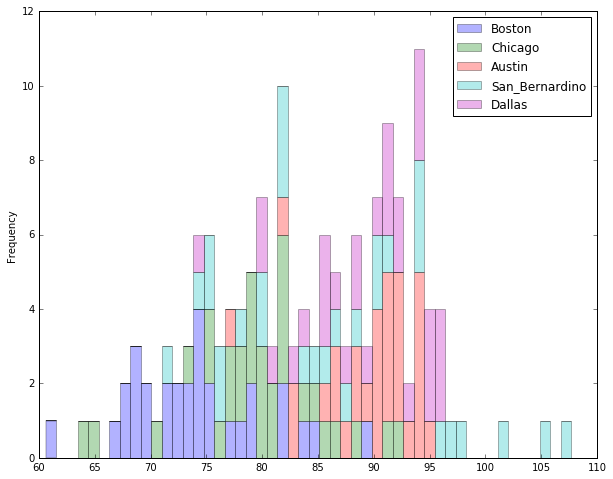

In [99]:
temps.plot.hist(stacked = True, alpha = 0.3, figsize=(10, 8), bins = 50)
plt.xticks(np.arange(60, 111, 5));

### We can see then location and mean temperature of the cities on a map

In [82]:
lats = []
longs = []
sites = []
for k,v in cities.iteritems():
    lats.append(float(v.split(',')[0]))
    longs.append(float(v.split(',')[1]))
    sites.append(k)

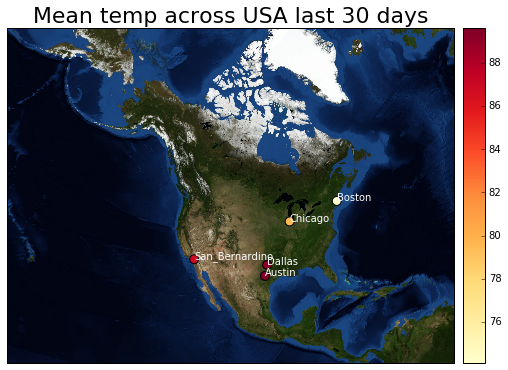

In [95]:
plt.figure(figsize=(12,6))
plt.title('Mean temp across USA last 30 days', fontsize = 22)
m = Basemap(width=12000000,height=9000000,projection='lcc',
            resolution=None,lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
m.bluemarble()

x,y = m(longs, lats)
labels = sites
cmap = plt.get_cmap('YlOrRd')
cor = temps.mean()
cax = cm.ScalarMappable(cmap=cmap)
cax.set_array(cor)

for label, xpt, ypt, in zip(labels, x, y):
    plt.text(xpt-500, ypt+100, label, color = 'white')

m.scatter(x=x, y=y, s = 80, c = cor, marker = 'o', cmap = cmap)
m.colorbar(cax)
plt.show()